# Tech Challenge (Data Sciences)

   ### Baptiste CHAIGNEAU

# 

# Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score

# 

# Exploration des données Sales

In [3]:
'''
Le format de la variable DATE doit être modifié pour être comparé aux futures données
L'utilisation du pivot_table permet de mettre chaque ITEM de vente selon le temps
'''

sales = pd.read_csv('sales_data.txt', sep = ',')

sales['DATE'] = pd.to_datetime(sales['DATE'])
sales['DATE'] = sales['DATE'].dt.strftime('%Y-%m-%d')

sales_daily = pd.pivot_table(
    data = sales, 
    values = 'SALES', 
    index = 'DATE', 
    columns = 'ITEM'
    ).reset_index()

C:\Users\baptc\AppData\Local\Temp\ipykernel_2728\3300581362.py:8: UserWarning: Parsing '13-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['DATE'] = pd.to_datetime(sales['DATE'])
C:\Users\baptc\AppData\Local\Temp\ipykernel_2728\3300581362.py:8: UserWarning: Parsing '16-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['DATE'] = pd.to_datetime(sales['DATE'])
C:\Users\baptc\AppData\Local\Temp\ipykernel_2728\3300581362.py:8: UserWarning: Parsing '17-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['DATE'] = pd.to_datetime(sales['DATE'])
C:\Users\baptc\AppData\Local\Temp\ipykernel_2728\3300581362.py:8: UserWarning: Parsing '18-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['DATE'] = pd.to_datetime(sales['DATE'])
C:\Users\bap

In [4]:
'''
A priori il n'y a pas d'outliers, ni NaNs, ni de lignes qui se répètent dans le temps. 
La distribution semble crédible.
'''

print(sales.describe())
print()
print('Is there some NaNs ? :', sales.isnull().values.any())
print()
print('Is the time series not repeating ? :', sales_daily.index.is_unique)

            SALES
count  520.000000
mean    98.207692
std     61.444707
min      0.000000
25%     48.000000
50%     87.000000
75%    143.000000
max    282.000000

Is there some NaNs ? : False

Is the time series not repeating ? : True


In [5]:
'''
Certains jours de l'année sont manquants. Il s'agit de les identifier.

    - Création d'un DataFrame des jours de l'année puis comparaison avec notre df
    - Output : 105 jours non travaillés/sans vente dans l'année 2019

'''

year = pd.DataFrame(
    pd.date_range(start="2019-01-01",end="2019-12-31").strftime('%Y-%m-%d').tolist(), 
    columns = ['DATE']
    )
unique_days = year.query('DATE not in @sales_daily.DATE')
print(unique_days)

           DATE
0    2019-01-01
3    2019-01-04
6    2019-01-07
9    2019-01-10
13   2019-01-14
..          ...
350  2019-12-17
356  2019-12-23
357  2019-12-24
363  2019-12-30
364  2019-12-31

[105 rows x 1 columns]


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


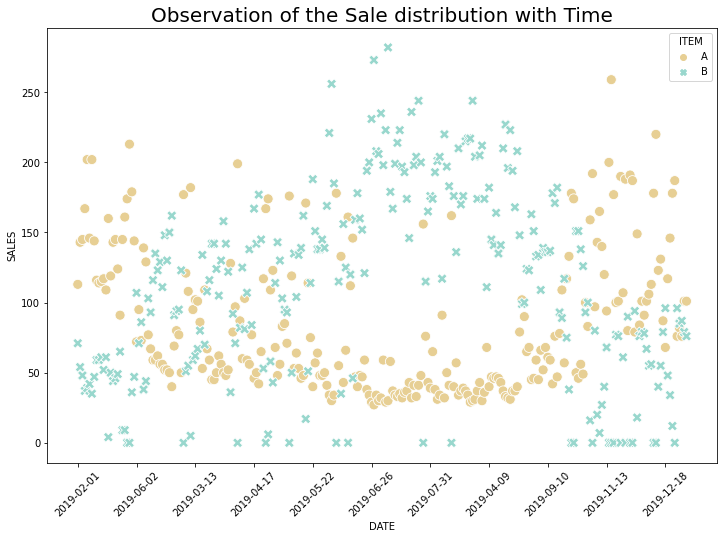

In [6]:
'''
Un coup d'oeil rapide pour observer la distribution des ventes
de chaque paramètre dans l'année.

Qualitativement, il y a une anticorrélation claire entre A et B
et un effet saisonnal
'''

fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(
    data = sales, 
    x = 'DATE', y ='SALES', 
    hue = 'ITEM', 
    style = 'ITEM', 
    s = 100, 
    palette = 'BrBG'
    )
ax.xaxis.set_major_locator(mticker.MaxNLocator(12))
plt.xticks(rotation = 45)
plt.title('Observation of the Sale distribution with Time', fontsize = 20)
plt.show()


# 

# Etude de la corrélation entre les ventes et la météo

In [7]:
'''
Dans un but exploratoire, on peut réaliser une corrélation
bivariée entre A, B et les variables météo.

    - Création des df meteo de chaque ville
    - La fonction corr réalise la corrélation pour chaque paramètre.
      On ne sélectionne que celles liées à A et B.
    - On stock le résultat dans meteo_corr
'''

towns = [
    'bordeaux', 
    'lille', 
    'lyon', 
    'marseille'
    ]

meteo_corr = pd.DataFrame(columns = ['A', 'B', 'town'])


for idx, t in enumerate(towns) :
    globals()[t] = pd.read_csv('meteo_{}.txt'.format(t), sep = ',', skiprows = 3)    
    result = pd.merge(
        sales_daily, globals()[t], 
        on = 'DATE'
        )  
    corr = result.corr()
    df = pd.DataFrame()
    df['A'] = corr.A
    df['B'] = corr.B
    df['town'] = t
    meteo_corr = pd.concat([meteo_corr, df])

meteo_corr = meteo_corr.reset_index()
meteo_corr = meteo_corr[(meteo_corr['index'] != 'A') 
                        & (meteo_corr['index'] != 'B')]

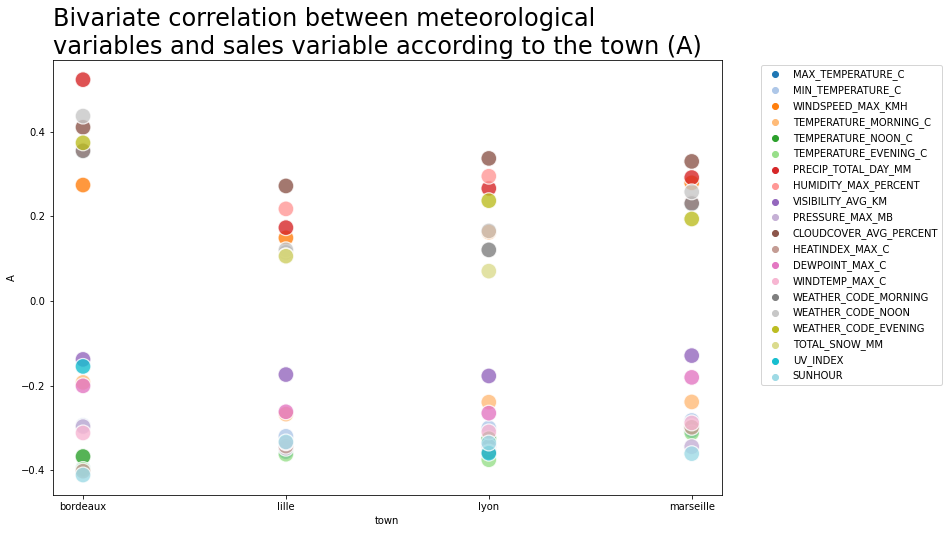

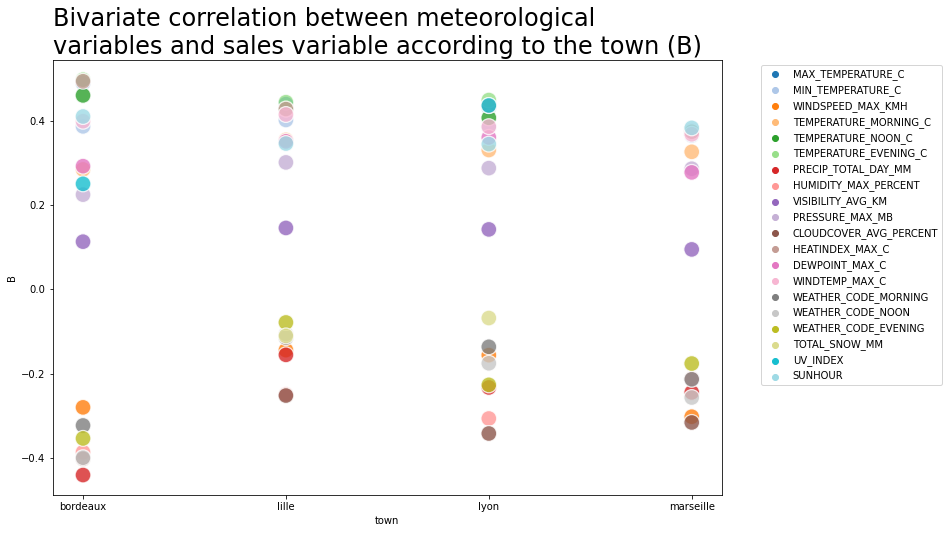

In [357]:
'''
Plot des corrélations bivariées pour A et B

Qualitativement, la météo de Bordeaux est plus corrélée avec le produit des ventes.
Un lien plus fort avec l'humidité/precipitation? 
'''

var = [
       'A', 'B'
        ]

for v in var : 
    fig, ax = plt.subplots(figsize = (12,8))
    
    sns.set_palette("tab20")
    sns.scatterplot(
        data = meteo_corr,
        x = 'town', y = '{}'.format(v), hue = 'index',
        s = 250,
        alpha = 0.8
        )
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.title(
        'Bivariate correlation between meteorological\nvariables and sales variable according to the town ({})'.format(v),
        fontsize = 24,
        loc = 'left'
        )

In [55]:
'''
Pour identifier les variables à enjeux sur le site de Bordeaux, 
il est possible de faire la somme de la corrélation absolue entre A et B. 
Le résultat permet de mieux visualiser quelles variables ont un intérêt 
plus important pour les deux produits.

Il semblerait que les précipitations et les maximums de température (T ressentie, T_max, T_evening) 
sont de plus grande importance que le reste, et surtout que les vents.
'''

selec_town = 'bordeaux'

bdx_corr = meteo_corr[meteo_corr['town'] == '{}'.format(selec_town)]
bdx_corr['sum'] = bdx_corr.loc[:,'A'].abs() + bdx_corr.loc[:,'B'].abs()
bdx_corr.sort_values(by = ['sum'])

C:\Users\baptc\AppData\Local\Temp\ipykernel_2728\1651195093.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdx_corr['sum'] = bdx_corr.loc[:,'A'].abs() + bdx_corr.loc[:,'B'].abs()


,index,A,B,town,sum
10,VISIBILITY_AVG_KM,-0.137895,0.112948,bordeaux,0.250843
20,UV_INDEX,-0.154532,0.250194,bordeaux,0.404726
5,TEMPERATURE_MORNING_C,-0.192233,0.284469,bordeaux,0.476702
14,DEWPOINT_MAX_C,-0.200374,0.292141,bordeaux,0.492515
11,PRESSURE_MAX_MB,-0.296591,0.224537,bordeaux,0.521129
4,WINDSPEED_MAX_KMH,0.273759,-0.280258,bordeaux,0.554016
16,WEATHER_CODE_MORNING,0.354451,-0.323245,bordeaux,0.677695
3,MIN_TEMPERATURE_C,-0.293953,0.38663,bordeaux,0.680583
15,WINDTEMP_MAX_C,-0.311605,0.398815,bordeaux,0.71042
18,WEATHER_CODE_EVENING,0.373392,-0.353925,bordeaux,0.727317


# 

# Prédiction des ventes

In [361]:
'''
Import des données à prédire
Seul une partie des variables sont présentes dans
les données à prédire.
'''

forecast = pd.read_csv('forecast.txt')
forecast.columns

Index(['DATE', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT'],
      dtype='object')

## Preprocessing

In [340]:
'''
Raccordement des données sales et de la météo de Bordeaux.

L'effet temps est transformé en informations mensuelles,
hebdomadaires et quotidiennes
'''

full_df = pd.merge(sales_daily, globals()[selec_town][forecast.columns])


full_df['DATE'] =  pd.to_datetime(full_df['DATE'], format='%Y-%m-%d')
full_df['MONTH'] = full_df['DATE'].dt.month
full_df['WEEK'] = full_df['DATE'].dt.isocalendar().week
full_df['DAY_WEEK'] = full_df['DATE'].dt.dayofweek
full_df['DAY'] = full_df['DATE'].dt.day

In [341]:
'''
Certaines variables sont retirées :
    - A, B : sont les variables dépendantes
    - DATE : car l'information a été mise dans plusieurs
             colonnes.
'''

X_prep = full_df.drop(
    ['A', 'B', 'DATE'],
    axis = 1
    )

In [342]:
'''
Pour donner un poid égal à chaque variable il est nécessaire
de normaliser les données. (entre 0 et 1)
'''

scaler = MinMaxScaler()
scaler.fit(X_prep)
X_prep = pd.DataFrame(
    scaler.transform(X_prep), 
    columns = X_prep.columns
    )

## Produit A

In [364]:
'''
Séparation du jeu de données en :
    - données d'entrainnements (train)
    - données de test après apprentissage (test)
    
Utilisation de la validation croisée pour observer la 
robsutesse de la prédiction via plusieurs tests.

Utilisation du modèle Forêt Aléatoire 
(après plusieurs essais de modèles) :
    - nombre d'arbres : 1000

Metrics :
    - Mean Squared Error (MSE)
    - R² 
'''

X = X_prep
y = full_df['A']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 35)

model = RandomForestRegressor(
    n_estimators = 1000, 
    random_state = 35
    )
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, 
                         X_train, y_train, 
                         scoring = make_scorer(mean_squared_error), 
                         cv=cv, 
                         n_jobs=-1
                        )
print('Produit A :')
print('Accuracy (MSE): %.3f' % (np.mean(scores)))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('MSE', mean_squared_error(y_test, y_pred))
print('R²', r2_score(y_test, y_pred))

Produit A :
Accuracy (MSE): 853.315
MSE 1131.4215020384615
R² 0.6628611189859575


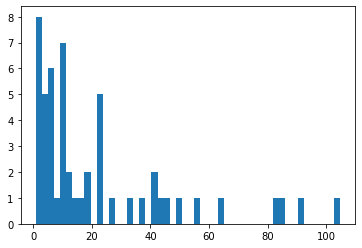

In [365]:
'''
Plot de l'erreur de la distribution absolue entre 
la prédiction des données test et les vraies valeurs
'''

err = np.abs(y_pred - y_test)

plt.hist(err, bins = 50)
plt.show()

### Predictions

In [367]:
'''
On homogénéise les données à prédire comme celles
qui ont été entrainées.
'''
forecast = pd.read_csv('forecast.txt')

forecast['DATE'] =  pd.to_datetime(forecast['DATE'], format='%Y-%m-%d')
forecast['MONTH'] = forecast['DATE'].dt.month
forecast['WEEK'] = forecast['DATE'].dt.isocalendar().week
forecast['DAY_WEEK'] = forecast['DATE'].dt.dayofweek
forecast['DAY'] = forecast['DATE'].dt.day
forecast = forecast.drop(columns = 'DATE', axis = 1)

forecast

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,MONTH,WEEK,DAY_WEEK,DAY
0,20,14,23,2.0,92,7.0,1025,61.0,6,25,0,21
1,25,17,10,0.0,73,9.0,1027,26.0,6,25,1,22
2,25,18,19,0.0,79,10.0,1024,19.0,6,25,2,23
3,32,23,12,0.0,76,10.0,1018,2.0,6,25,3,24
4,28,20,13,1.0,82,10.0,1015,36.0,6,25,4,25
5,20,16,19,0.0,88,9.0,1013,89.0,6,25,5,26
6,21,15,31,1.0,89,9.0,1015,76.0,6,25,6,27


In [369]:
'''
La moyenne et l'écart type de la prédiction des ventes pour A
'''

A_pred = model.predict(forecast)
print('mean sales :', A_pred.mean())
print('Ecart type :', A_pred.std())

mean sales : 103.83528571428572
Ecart type : 45.97338247201708


## Produit B

In [370]:
X = X_prep
y = full_df['B']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 35)

model = RandomForestRegressor(
    n_estimators = 1000, 
    random_state = 35
    )
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, 
                         X_train, y_train, 
                         scoring = make_scorer(mean_squared_error), 
                         cv=cv, 
                         n_jobs=-1
                        )
print('Produit B :')
print('Accuracy (MSE): %.3f' % (np.mean(scores)))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('MSE', mean_squared_error(y_test, y_pred))
print('R²', r2_score(y_test, y_pred))

Produit B :
Accuracy (MSE): 1344.842
MSE 1791.1307386538463
R² 0.6711654358508767


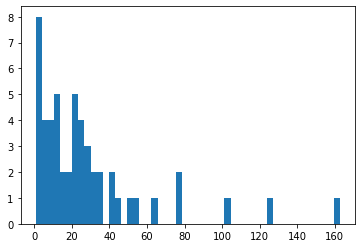

In [371]:
err = np.abs(y_pred - y_test)

plt.hist(err, bins = 50)
plt.show()

### Prediction

In [372]:
'''
La moyenne et l'écart type de la prédiction des ventes pour B
'''

B_pred = model.predict(forecast)
print('mean sales :', B_pred.mean())
print('Ecart type :', B_pred.std())

mean sales : 189.7611428571429
Ecart type : 34.90217953664446


# Conclusion

In [ ]:
'''
Bernardo devrait alors s'attendre à vendre durant les prochains jours:
    - 104 éléments A
    - 189 éléments B
(Mais il faut s'attendre à une incertitude de plusieurs dizaines d'éléments)
'''